## Metric 3b: Number of days with heavy wildfire smoke density 

In [11]:
import numpy as np
import numpy.ma as ma
import os
from datetime import datetime, timedelta 
import csv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

In [12]:
current_directory = os.path.dirname(os.getcwd())

In [13]:
# Daily Averaged WFS PM2.5 data by Census Tract
relative_path = "Output/Data/Daily_Average_WFS_PM25_by_Census_Tract.csv"
grouped_data_path = os.path.join(current_directory, relative_path)
PM25_by_Tracts_WFS = pd.read_csv(grouped_data_path)

# Census Tracts Shapefile
relative_sf_path = "Raw_Data/Shapefiles/Tracts2020_MatchedExtent.shp"
grouped_data_CT_path = os.path.join(current_directory, relative_sf_path)
Tracts2020 = gpd.read_file(grouped_data_CT_path)
Tracts2020 = Tracts2020.to_crs(epsg=3338) # NAD AK Albers projection (better to project maps of AK only)

In [14]:
# Maps Output Folder Path
output_folder = os.path.join(current_directory, "Output")

In [15]:
# Convert Date to datetime and extract Year
PM25_by_Tracts_WFS['Date'] = pd.to_datetime(PM25_by_Tracts_WFS['Date'])
PM25_by_Tracts_WFS['Year'] = PM25_by_Tracts_WFS['Date'].dt.year

# Filter to Wildfire Season (May-Sept)
WFS_M3b_Year_Tract = PM25_by_Tracts_WFS[PM25_by_Tracts_WFS['Date'].dt.month.isin([5, 6, 7, 8, 9])]

# Filter for heavy smoke days (PM2.5 >= 35.5)
heavy_smoke_days_raw = WFS_M3b_Year_Tract[WFS_M3b_Year_Tract['PM2.5'] >= 35.5]

# Count occurrences by tract and year
heavy_counts = heavy_smoke_days_raw.groupby(['NAME', 'Year']).size().reset_index(name='heavy_smoke_days')

# --- Ensure all NAME-Year combinations are represented ---
# Get all unique tracts and years
all_names = PM25_by_Tracts_WFS['NAME'].unique()
all_years = PM25_by_Tracts_WFS['Year'].unique()

# Create a full index of all combinations
import pandas as pd
import itertools

full_index = pd.DataFrame(list(itertools.product(all_names, all_years)), columns=['NAME', 'Year'])

# Merge with actual counts, fill missing with 0
heavy_smoke_complete = pd.merge(full_index, heavy_counts, on=['NAME', 'Year'], how='left').fillna(0)

# Pivot for wide format, fillna not needed now but safe to include
heavy_smoke_pivot = heavy_smoke_complete.pivot(index='NAME', columns='Year', values='heavy_smoke_days').fillna(0)

# Add Total column
heavy_smoke_pivot['Total'] = heavy_smoke_pivot.sum(axis=1)

# Reset index for easier merging/display
heavy_smoke_pivot.reset_index(inplace=True)

# Ensure integer values
heavy_smoke_pivot.loc[:, heavy_smoke_pivot.columns != 'NAME'] = heavy_smoke_pivot.loc[:, heavy_smoke_pivot.columns != 'NAME'].astype(int)

heavy_smoke_pivot

/tmp/ipykernel_191/476385332.py:38: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  heavy_smoke_pivot.loc[:, heavy_smoke_pivot.columns != 'NAME'] = heavy_smoke_pivot.loc[:, heavy_smoke_pivot.columns != 'NAME'].astype(int)


Year,NAME,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Total
0,Abbott Loop,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,8,0,11
1,Abbott Loop North,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,8,0,11
2,Abbott Loop West,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,8,0,11
3,Airport Heights,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,8,0,11
4,Airport Way Central,2,42,14,0,0,0,12,1,1,0,2,0,16,0,0,1,11,0,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Wonder Park,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,8,0,11
173,Woodland Park/Spenard,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,8,0,11
174,Wrangell,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
175,Yakutat,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [16]:
# All counts of days above 35.5 for the years of data we have
relative_heavy_smoke_days_path = "Output/Data/heavy_smoke_days.csv"
grouped_heavy_smoke_days_path = os.path.join(current_directory, relative_heavy_smoke_days_path)
heavy_smoke_pivot.to_csv(grouped_heavy_smoke_days_path, index=False)

### Data Visualization

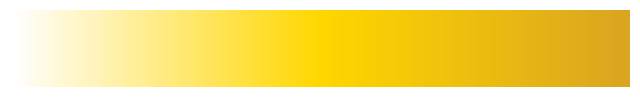

In [17]:
# Define colors: White -> Gold -> Goldenrod
colors = ["white", "gold", "goldenrod"]
WhiteToGoldenrod = mcolors.LinearSegmentedColormap.from_list("WhiteToGoldenrod", colors)

# Test the colormap with a gradient
gradient = np.linspace(0, 1, 256).reshape(1, -1)

fig, ax = plt.subplots(figsize=(8, 1))
ax.imshow(gradient, aspect="auto", cmap=WhiteToGoldenrod)
ax.set_axis_off()
plt.show()

## Panel Map

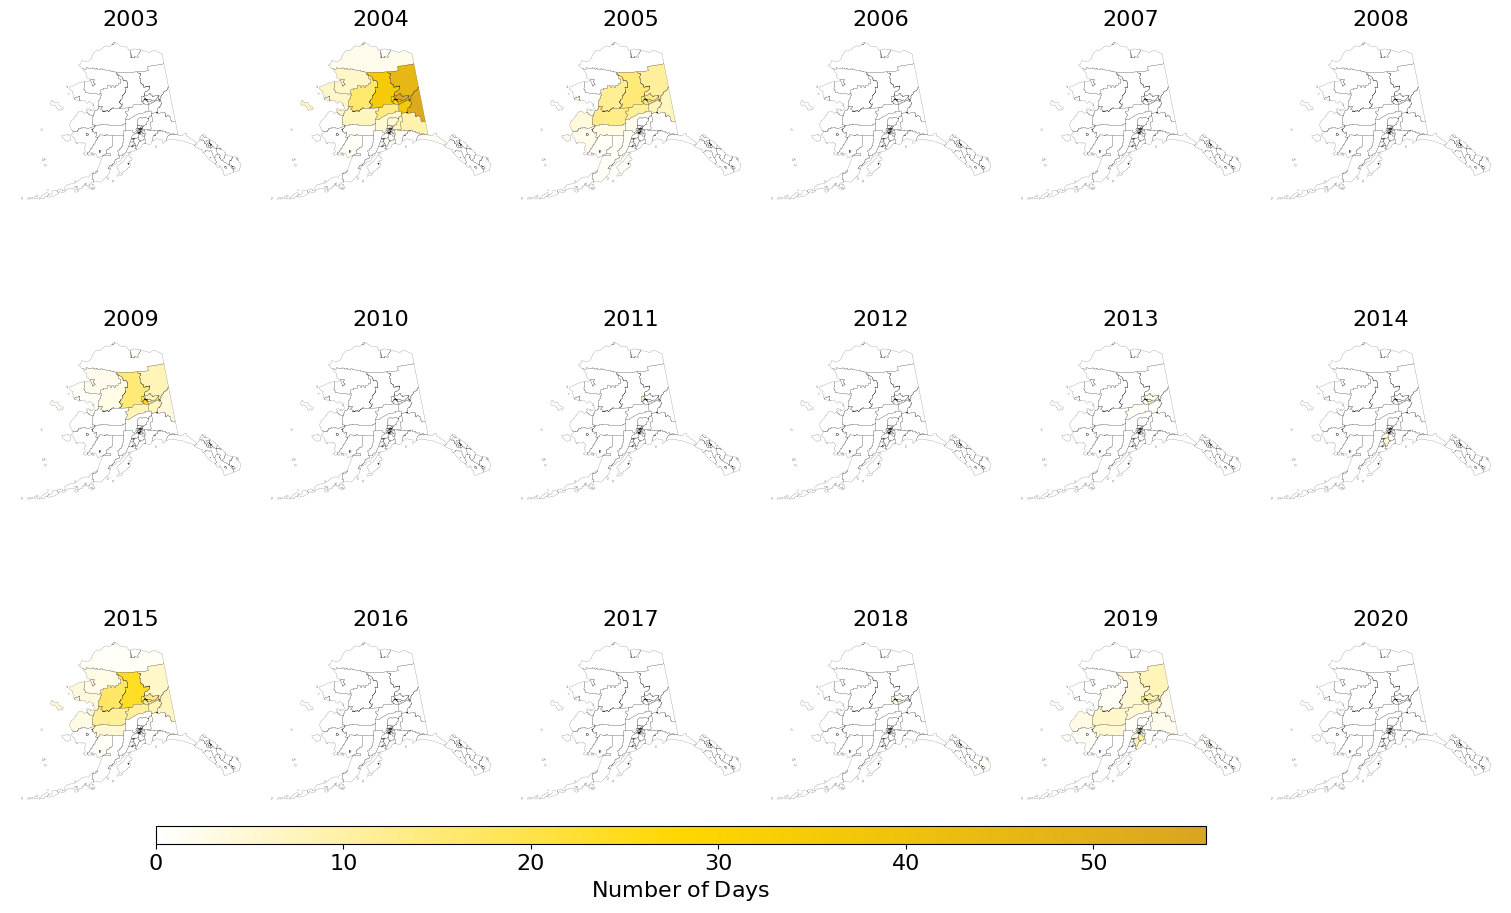

In [18]:
# Set the number of rows and columns for the panel (adjust if needed)
num_rows = 3
num_cols = 6

# Create a figure and GeoAxes with the Albers Equal Area projection for Alaska
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
fig, axes = plt.subplots(num_rows, num_cols, subplot_kw={'projection': alaska_albers}, figsize=(15, 9), constrained_layout=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Ensure only year columns are included for plotting (excluding 'NAME' and 'Total')
year_columns = [col for col in heavy_smoke_pivot.columns if col != 'NAME' and col != 'Total']

# Define min and max values for color scaling across all plots
vmin = 0
vmax = heavy_smoke_pivot[year_columns].max().max()  # Maximum value in all years for consistent color scaling

# Iterate over each year
for i, year in enumerate(year_columns):
    if i >= len(axes):
        break  # In case there are more years than subplots available
    
    # Prepare the data for the current year
    merged_data = Tracts2020.merge(
        pd.DataFrame({
            'NAME': heavy_smoke_pivot['NAME'],
            'Days_Above_Moderate': heavy_smoke_pivot[year]
        }),
        on='NAME', how='inner'
    )

    # Add thin black border to the shapefile data
    merged_data.boundary.plot(ax=axes[i], color='black', linewidth=0.10, transform=alaska_albers)

    # Plot the shapefile with color based on Days_Above_Moderate values
    merged_data.plot(
        ax=axes[i],
        column='Days_Above_Moderate',
        cmap=WhiteToGoldenrod,
        transform=alaska_albers,
        legend=False,
        vmin=vmin,
        vmax=vmax,
        edgecolor='none'
    )

    # Set plot title for each year
    axes[i].set_title(f"{year}", fontsize=16)

    # Remove axes ticks and labels
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
    axes[i].set_frame_on(False)

# Adjust the position of the colorbar axes
ticks = np.arange(0, vmax + 10, 10)

# Adjust the position of the colorbar axes
cbar_ax = fig.add_axes([0.1, 0.03, 0.7, 0.02])

# Add colorbar to the figure
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=WhiteToGoldenrod),
    cax=cbar_ax, orientation='horizontal', ticks=ticks
)
cbar.set_label(r'$\mathrm{Number\;of\;Days}$', fontsize=16)  # Increase title size
cbar_ax.tick_params(labelsize=16)  # Increase tick label size

# Export
output_file_path = f"{output_folder}/Panel_Maps/heavy_smoke_days_Panel.png"
plt.savefig(output_file_path, dpi=600, bbox_inches='tight')

plt.show()

## Annual Maps

In [19]:
# Define the Albers Equal Area projection for Alaska
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)

# Ensure only year columns are included for plotting (excluding 'NAME' and 'Total')
year_columns = [col for col in heavy_smoke_pivot.columns if col not in ['NAME', 'Total']]

# Define min and max values for color scaling across all plots
vmin = 0
vmax = heavy_smoke_pivot[year_columns].max().max()  # Maximum value in all years for consistent color scaling

# Generate tick positions for colorbar
ticks = np.arange(0, vmax + 10, 10)

# Iterate over each year
for year in year_columns:
    # Prepare the data for the current year
    merged_data = Tracts2020.merge(
        pd.DataFrame({
            'NAME': heavy_smoke_pivot['NAME'],
            'Days_Above_Moderate': heavy_smoke_pivot[year]
        }),
        on='NAME', how='inner'
    )
    
    # Create a new figure for each year
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': alaska_albers}, figsize=(10, 8))
    
    # Add thin black border to the shapefile data
    merged_data.boundary.plot(ax=ax, color='black', linewidth=0.10, transform=alaska_albers)

    # Plot the shapefile with color based on Days_Above_Moderate values
    merged_data.plot(
        ax=ax,
        column='Days_Above_Moderate',
        cmap=WhiteToGoldenrod,
        transform=alaska_albers,
        legend=False,
        vmin=vmin,
        vmax=vmax,
        edgecolor='none'
    )

    # Add a colorbar for the individual map
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=WhiteToGoldenrod),
        ax=ax,
        orientation='horizontal',
        fraction=0.046, pad=0.04, ticks=ticks
    )
    cbar.set_label(r'$\mathrm{Number\;of\;Days}$')

    # Set the title for the map
    ax.set_title(f"Days Above 35.5 PM2.5 - {year}", fontsize=14)

    # Remove axes ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')  # Remove the frame

    # Save the individual map to the output folder
    output_file_path = f"{output_folder}/Annual_Maps/heavy_smoke_days_{year}.png"
    plt.savefig(output_file_path, dpi=600, bbox_inches='tight')
    
    # Close the figure to release memory
    plt.close(fig)

print("All individual maps have been saved to:", output_folder)

All individual maps have been saved to: /mnt/c/Users/nrathauda/OneDrive - University of Alaska/NIMHD K01 - wildfire and birth outcomes/Alaska_wildfire-smoke-metrics_2025/Output


## Cumulative Map

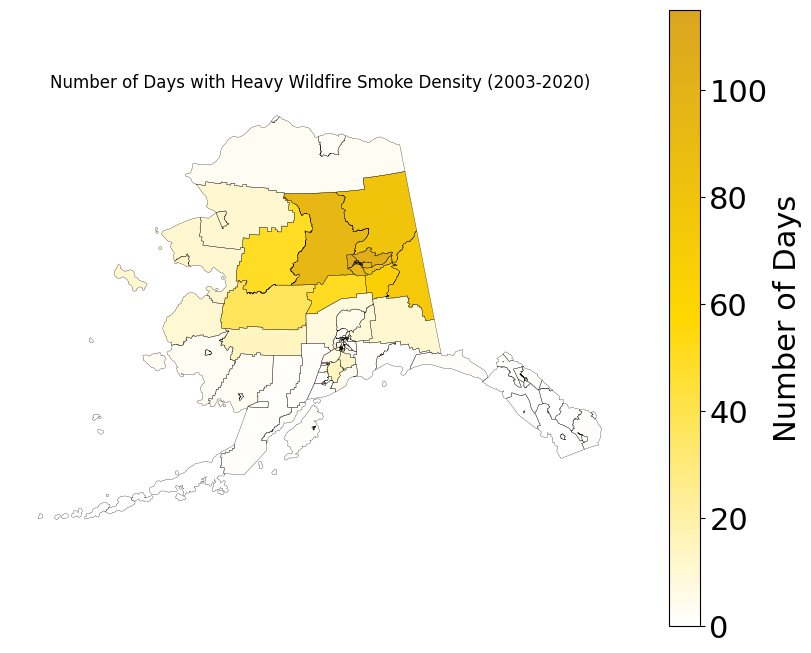

In [20]:
# Merge shapefile with the average PM2.5 data
merged_data = Tracts2020.merge(heavy_smoke_pivot, on='NAME', how='inner')

# Create a figure and GeoAxes with the Albers Equal Area projection
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
fig, ax = plt.subplots(subplot_kw={'projection': alaska_albers}, figsize=(10, 8))

# Add thin black border to the shapefile data
Tracts2020.boundary.plot(ax=ax, color='black', linewidth=0.20, transform=alaska_albers)
vmin = 0
vmax = merged_data['Total'].max()

# Plot the shapefile with color based on Average_PM25 values
plot = merged_data.plot(
    ax=ax, column='Total', cmap=WhiteToGoldenrod, legend=True, transform=alaska_albers, vmin=vmin, vmax=vmax
)

# Colorbar label text sizing
cbar = plot.get_figure().get_axes()[-1] 
cbar.set_ylabel("Number of Days", fontsize=22)  # Increase title size
cbar.tick_params(labelsize=22)  # Increase tick label size

# Remove axes ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.axis('off')

# Export without title
wfs_m3b_cumul_relative_path = "Output/Cumulative_Maps/heavy_smoke_days_Cumulative.png"
wfs_m3b_cumul_path = os.path.join(current_directory, wfs_m3b_cumul_relative_path)
plt.savefig(wfs_m3b_cumul_path, dpi=300, bbox_inches='tight')

# Set plot title
ax.set_title('Number of Days with Heavy Wildfire Smoke Density (2003-2020)')

# Export with title
wfs_m3b_cumul_relative_path = "Output/Cumulative_Maps/heavy_smoke_days_Cumulative_wTitle.png"
wfs_m3b_cumul_path = os.path.join(current_directory, wfs_m3b_cumul_relative_path)
plt.savefig(wfs_m3b_cumul_path, dpi=300, bbox_inches='tight')

plt.show()
plt.close()